# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os, gc, re, joblib
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import anndata
import scanpy as sc
# import scanpy_scripts as ss
import sctk as sk
import bbknn
import phate

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = sk.expression_colormap()

/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sk.set_figsize((4, 4))

# Load data

In [3]:
cc_genes = pd.read_csv('../data/external/cc_genes.list', header=None, names=['gene']).gene.to_list()

In [4]:
samples = [f'R{i+1:02d}' for i in range(13)]

In [5]:
os.getcwd()

'/lustre/scratch126/cellgen/team205/sk29/matthias_fb/20200715_scRNA_batch1_2'

In [6]:
raw_ads = [sc.read(f'../data/rna/{s}.Gene.cr3.h5ad') for s in samples]

Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].
Only considering the two last: ['.cr3', '.h5ad'].


In [7]:
scrublets = [pd.read_csv(f'../data/rna/scrublet/{s}.Gene.cr3.scrublet.csv', index_col=0) for s in samples]

In [8]:
for i, s in enumerate(samples):
    raw_ads[i].obs['scrublet_score'] = scrublets[i]['scrublet_score'].values
    raw_ads[i].obs['doublet_bh_pval'] = scrublets[i]['doublet_bh_pval'].values

metadata

In [11]:
# meta_df = pd.read_csv('../data/clinical_data.csv')
meta_df = pd.read_csv('../data/sample_metadata.csv')

In [12]:
meta_df.head(2)

GEX_SID ATAC_SID   GEX  ATAC  Sample Donor         DOB Gender        date  \
0     R01      A01  GX46  NX02  110543    d1  24/10/1951      M  21/06/2018   
1     R02      A02  GX34  NX10  110544    d1  24/10/1951      M  21/06/2018   

   age_years         state disease site_taken_fine site_taken_broad  \
0         66      inflamed      CD      ileo-colon  small intestine   
1         66  non-inflamed      CD      ileo-colon  small intestine   

                       sorted  Nancy_histologic_score  \
0  CD45-EPCAM-CD31-THY1+PDPN+                     4.0   
1  CD45-EPCAM-CD31-THY1+PDPN+                     0.0   

                       slide_look_other whole_tissue_signature     scSeq  \
0  ulcers, granulation tissue (swapped)                   M4M5  RNA+ATAC   
1                                normal                     M6  RNA+ATAC   

           bulkSeq  
0  ATAC + CD45+RNA  
1  ATAC + CD45+RNA

In [13]:
raw_ad = anndata.AnnData.concatenate(*raw_ads, batch_key='sample_id', batch_categories=samples)

In [14]:
raw_ad

AnnData object with n_obs × n_vars = 45683 × 17707
    obs: 'n_counts', 'scrublet_score', 'doublet_bh_pval', 'sample_id'
    var: 'gene_ids', 'n_counts-R01', 'n_counts-R02', 'n_counts-R03', 'n_counts-R04', 'n_counts-R05', 'n_counts-R06', 'n_counts-R07', 'n_counts-R08', 'n_counts-R09', 'n_counts-R10', 'n_counts-R11', 'n_counts-R12', 'n_counts-R13'

In [16]:
# raw_ad.var = raw_ad.var[['gene_ids-R01']].rename(columns={'gene_ids-R01': 'gene_ids'}).copy()
# Simon not necesary?

In [17]:
obs_df = raw_ad.obs.reset_index().merge(meta_df, how='left', left_on='sample_id', right_on='GEX_SID').set_index('index')

In [18]:
np.all(obs_df.index == raw_ad.obs_names)

True

In [19]:
raw_ad.obs = obs_df

In [20]:
sk.calculate_qc(raw_ad)

In [21]:
raw_ad

AnnData object with n_obs × n_vars = 45683 × 17707
    obs: 'n_counts', 'scrublet_score', 'doublet_bh_pval', 'sample_id', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'Donor', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'
    var: 'gene_ids', 'n_counts-R01', 'n_counts-R02', 'n_counts-R03', 'n_counts-R04', 'n_counts-R05', 'n_counts-R06', 'n_counts-R07', 'n_counts-R08', 'n_counts-R09', 'n_counts-R10', 'n_counts-R11', 'n_counts-R12', 'n_counts-R13', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'

In [16]:
raw_ad.write('scRNA_batch1_2.raw.h5ad', compression='lzf')

... storing 'sample_id' as categorical
... storing 'GEX_SID' as categorical
... storing 'ATAC_SID' as categorical
... storing 'GEX' as categorical
... storing 'ATAC' as categorical
... storing 'DOB' as categorical
... storing 'Gender' as categorical
... storing 'date' as categorical
... storing 'state' as categorical
... storing 'disease' as categorical
... storing 'site_taken_fine' as categorical
... storing 'site_taken_broad' as categorical
... storing 'sorted' as categorical
... storing 'slide_look_other' as categorical
... storing 'whole_tissue_signature' as categorical
... storing 'scSeq' as categorical
... storing 'bulkSeq' as categorical


In [22]:
ad = sc.read('scRNA_batch1_2.processed.h5ad')

In [23]:
adS = sc.read('scRNA_batch1_2.processed.downsampled.h5ad')

Only considering the two last: ['.downsampled', '.h5ad'].
Only considering the two last: ['.downsampled', '.h5ad'].


In [24]:
adS

AnnData object with n_obs × n_vars = 4813 × 17590
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', '__is_in_cluster__'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'dendrogram_annot1', 'dendrogram_leiden_bk_split4', 'leiden', 'neighbors', 'neighbors_bk', 'pca', 'rank_genes_groups_ann

In [25]:
raw_adS = raw_ad[raw_ad.obs_names.isin(adS.obs_names)].copy()

In [26]:
np.all(raw_adS.obs_names == adS.obs_names)

True

In [27]:
raw_adS.obs['annot1'] = adS.obs['annot1'].copy()

In [28]:
raw_adS.obs.annot1.cat.categories

Index(['S3', 'S1', 'VE arterial tip', 'VE capillary', 'VE arterial',
       'VE postcapillary venlue', 'S3x', 'S5', 'S2', 'LE', 'MF1', 'MF2', 'PC',
       'GL', 'S4', 'IM'],
      dtype='object')

In [29]:
raw_adS.obs.annot1.cat.reorder_categories([
    'S1', 'S2', 'S3', 'S3x', 'S4', 'S5', 'MF1', 'MF2', 'PC',
    'VE arterial', 'VE arterial tip', 'VE capillary', 'VE postcapillary venlue', 'LE',
    'GL', 'IM'
], inplace=True)

In [24]:
raw_adS.write('scRNA_batch1_2.downsampled.raw.h5ad', compression='gzip')

# Process scRNA

## QC

In [30]:
sk.calculate_qc(raw_ad)

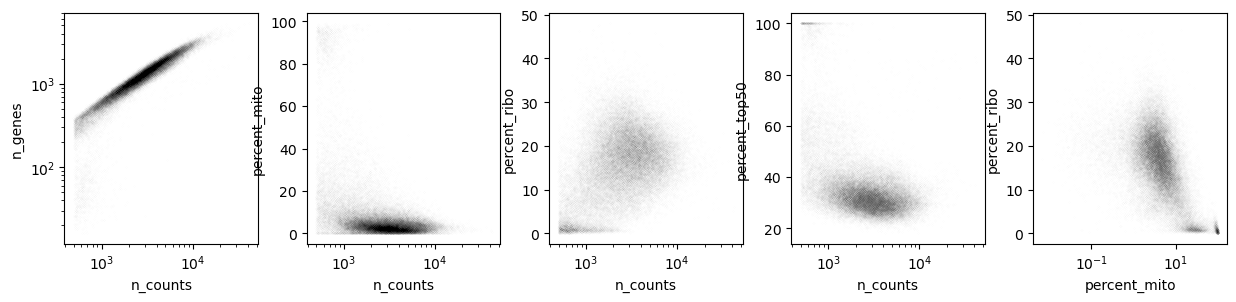

In [33]:
sk.plot_qc_scatter(raw_ad)

In [14]:
raw_ad1 = ss.lib.simple_default_pipeline(raw_ad, filter_only=True, filter_kw={'metrics': ['n_counts', 'percent_mito', 'percent_hb']})

In [18]:
raw_ad1.var['cc'] = raw_ad1.var_names.isin(cc_genes)

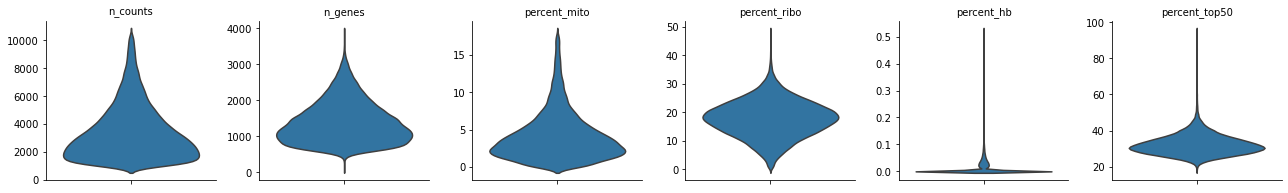

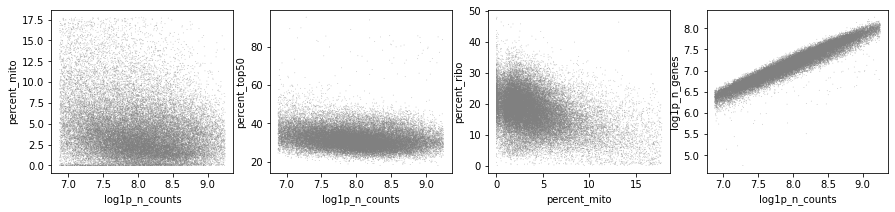

In [15]:
ss.lib.plot_qc(raw_ad1)

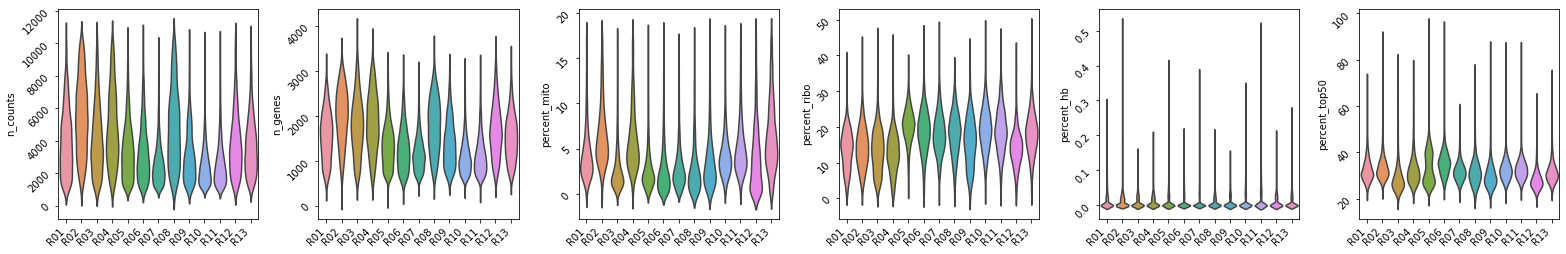

In [16]:
ss.lib.plot_qc(raw_ad1, groupby='sample_id', groupby_only=True)

## Run pipeline

In [19]:
raw_ad2 = ss.lib.remove_genes(raw_ad1, var_flags=['ribo', 'mito', 'hb'])

In [20]:
ad = ss.lib.simple_default_pipeline(
    raw_ad2, post_filter_only=True, batch='sample_id', batch_method='bbknn', do_clustering=False,
    hvg_kw={'by_batch': ('sample_id', 3), 'n_hvg': 3000},
    pca_kw={'remove_genes': ['cc']},
    bk_kw={'trim': 50}
)

In [51]:
raw_ad2.obs = raw_ad2.obs.reset_index().merge(meta_df, how='left', left_on='sample_id', right_on='GEX_SID').set_index('index')

In [52]:
raw_ad2.obs.sample_id.value_counts().sort_index(0)

R01    1902
R02    2553
R03    1409
R04    1822
R05    6317
R06    2297
R07    5428
R08    1031
R09    1078
R10    5122
R11    4850
R12    1493
R13    2814
Name: sample_id, dtype: int64

In [35]:
ad.obs = ad.obs.reset_index().merge(meta_df, how='left', left_on='sample_id', right_on='GEX_SID').set_index('index')

In [43]:
ad.obs.head(2)

doublet_bh_pval  n_counts sample_id  scrublet_score  \
index                                                                       
AAACCCATCGTGCTCT-R01         0.737696    1890.0       R01        0.286344   
AAACGAACATGTTACG-R01         0.737696    2811.0       R01        0.192308   

                      log1p_n_counts  n_genes  log1p_n_genes  percent_mito  \
index                                                                        
AAACCCATCGTGCTCT-R01        7.544861      888       6.790097     11.322752   
AAACGAACATGTTACG-R01        7.941651     1157       7.054450     11.988616   

                      percent_ribo  percent_hb  ...     state disease  \
index                                           ...                     
AAACCCATCGTGCTCT-R01     16.613756     0.05291  ...  inflamed      CD   
AAACGAACATGTTACG-R01     11.028104     0.00000  ...  inflamed      CD   

                     site_taken_fine site_taken_broad  \
index                                                   
AAACCCATCGTGCTCT-R01      ileo-colon  small intestine   
AAACGAACATGTTACG-R01      ileo-colon  small intestine   

                                          sorted  Nancy_histologic_score  \
index                                                                      
AAACCCATCGTGCTCT-R01  CD45-EPCAM-CD31-THY1+PDPN+                     4.0   
AAACGAACATGTTACG-R01  CD45-EPCAM-CD31-THY1+PDPN+                     4.0   

                                           slide_look_other  \
index                                                         
AAACCCATCGTGCTCT-R01  ulcers, granulation tissue (swapped?)   
AAACGAACATGTTACG-R01  ulcers, granulation tissue (swapped?)   

                     whole_tissue_signature     scSeq          bulkSeq  
index                                                                   
AAACCCATCGTGCTCT-R01                   high  RNA+ATAC  ATAC + CD45+RNA  
AAACGAACATGTTACG-R01                   high  RNA+ATAC  ATAC + CD45+RNA  

[2 rows x 30 columns]

In [36]:
ad

AnnData object with n_obs × n_vars = 38116 × 17590 
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'pca', 'neighbors_bk', 'neighbors', 'sample_id_colors'
    obsm: 'X_pca', 'X_umap_bk'
    varm: 'PCs'

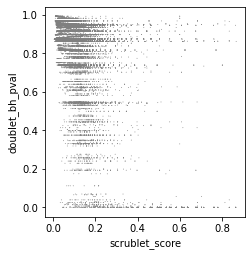

In [117]:
sc.pl.scatter(ad, x='scrublet_score', y='doublet_bh_pval')

In [118]:
ad.obs['is_doublet'] = (ad.obs.doublet_bh_pval < 0.5) | (ad.obs.scrublet_score > 0.3)

In [121]:
ad.obs['is_doublet'] = ad.obs['is_doublet'].astype('category')

### More QC

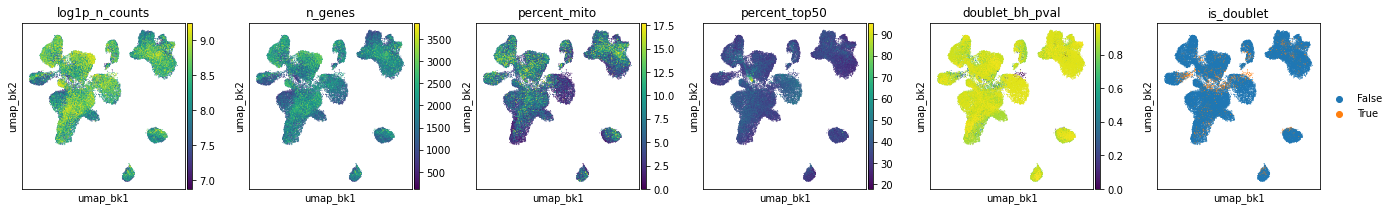

In [122]:
ss.lib.set_figsize((3, 3))
ss.lib.plot_scatter(ad, basis='umap_bk', color=['log1p_n_counts', 'n_genes', 'percent_mito', 'percent_top50', 'doublet_bh_pval', 'is_doublet'], ncols=6)

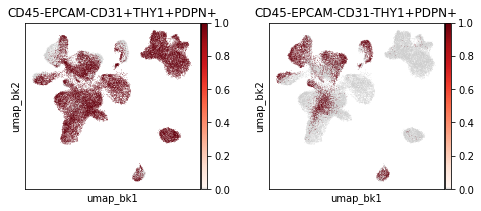

In [71]:
ss.lib.highlight(ad, basis='umap_bk', groupby='sorted', size=1, figsize=(3,3))

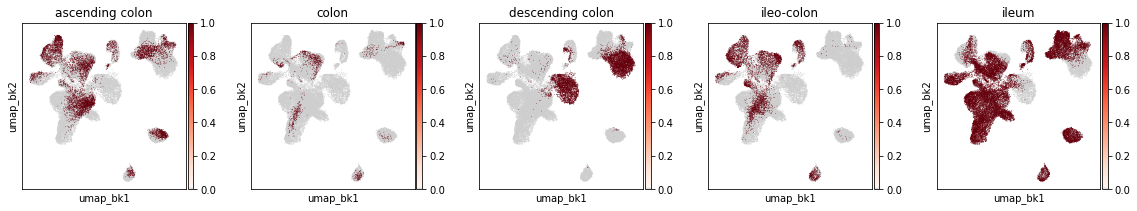

In [105]:
ss.lib.highlight(ad, basis='umap_bk', groupby='site_taken_fine', size=2, ncols=5, figsize=(3,3))

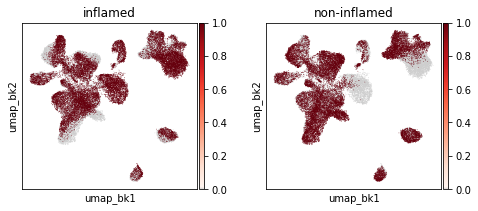

In [74]:
ss.lib.highlight(ad, basis='umap_bk', groupby='state', size=2, figsize=(3,3))

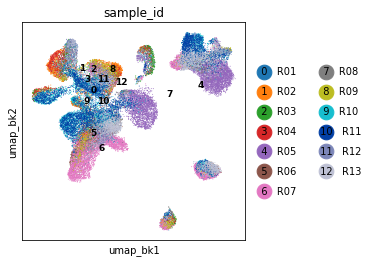

In [9]:
sk.plot_embedding(ad, basis='umap_bk', groupby='sample_id');

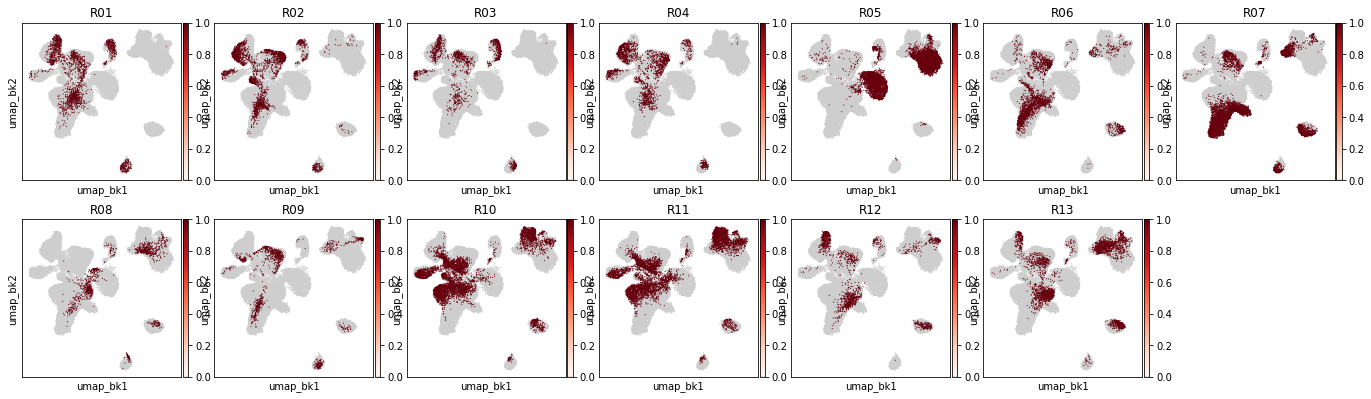

In [76]:
ss.lib.highlight(ad, basis='umap_bk', groupby='sample_id', size=5, figsize=(3,3), ncols=7, wspace=0.1, legend_loc='none')

In [113]:
ss.lib.leiden(ad, use_graph='neighbors_bk', resolution=[0.1, 0.3, 0.5], key_added='bk')

['leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5']

## Annotate

### Label transfer

#### Train LR model

##### Previous separate processing of two batches

In [83]:
batch1_ad = sc.read('../rna_processed.h5ad')

batch1_ad.obs.rename(columns={'sample': 'sample_id'}, inplace=True)
batch1_ad.obs['sample_id'].cat.rename_categories({'GX34': 'R01', 'GX46': 'R02', 'GX58': 'R03', 'GX70': 'R04'}, inplace=True)
batch1_ad.var.rename(columns={'gene_ids-GX34': 'gene_ids'}, inplace=True)

In [90]:
batch1_lr = ss.lib.LR_train(batch1_ad, groupby='annot_kinchen')

In [91]:
batch2_lr = ss.lib.LR_train(batch2_ad, groupby='annot')

##### Smillie19

In [215]:
gut_ad1 = sc.read('/home/ubuntu/projects/celltypist/20200220_quick_default_processing/smillie19-LP.processed.h5ad')
gut_ad2 = sc.read('/home/ubuntu/projects/celltypist/20200220_quick_default_processing/smillie19-Epi.processed.h5ad')
gut_ad1a = ss.lib.restore_adata(gut_ad1, restore_type='norm', obs_cols=['CellType'], var_cols=['gene_ids'])
gut_ad2a = ss.lib.restore_adata(gut_ad2, restore_type='norm', obs_cols=['CellType'], var_cols=['gene_ids'])
gut_ad = anndata.AnnData.concatenate(gut_ad1, gut_ad2)
gut_adS = ss.lib.subsample(gut_ad, fraction=0.05, groupby='CellType', min_n=100, max_n=300)

In [216]:
gut_adS

View of AnnData object with n_obs × n_vars = 5942 × 16276 
    obs: 'Barcodes', 'CellType', 'Dataset', 'DonorType', 'Other', 'Protocol', 'Tissue', 'batch', 'leiden', 'leiden_0.1', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'log1p_n_counts', 'log1p_n_genes', 'n_counts', 'n_genes', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'pw0.1_0.1', 'pw0.25_0.25', 'pw0.4_0.99', 'pw0.99_0.8', 'tiss_cl'
    var: 'gene_ids-0', 'mito-0', 'ribo-0', 'hb-0', 'n_counts-0', 'n_cells-0', 'n_genes-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'mito-1', 'ribo-1', 'hb-1', 'n_counts-1', 'n_cells-1', 'n_genes-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'

#### Predict

In [101]:
ss.lib.LR_predict(ad, batch1_lr, key_added='annot_batch1_lr')

In [104]:
ss.lib.LR_predict(ad, batch2_lr, key_added='annot_batch2_lr')

In [224]:
ss.lib.LR_predict(ad, gut_lr, key_added='annot_gut_lr')

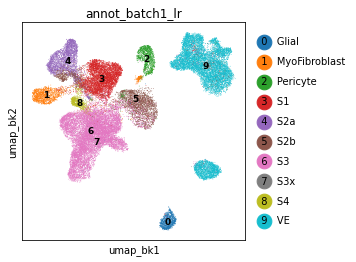

In [110]:
ss.lib.plot_embedding(ad, basis='umap_bk', groupby='annot_batch1_lr', size=2);

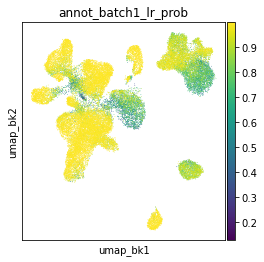

In [230]:
ss.lib.plot_scatter(ad, basis='umap_bk', color='annot_batch1_lr_prob', size=2);

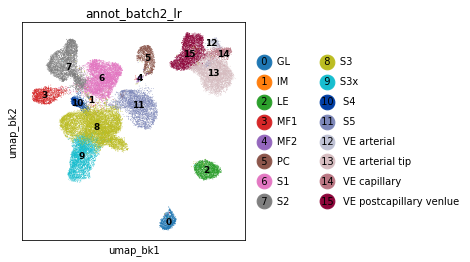

In [111]:
ss.lib.plot_embedding(ad, basis='umap_bk', groupby='annot_batch2_lr', size=2);

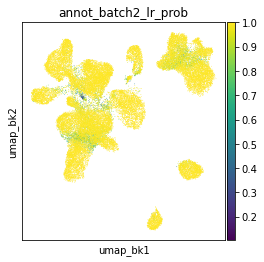

In [229]:
ss.lib.plot_scatter(ad, basis='umap_bk', color='annot_batch2_lr_prob', size=2);

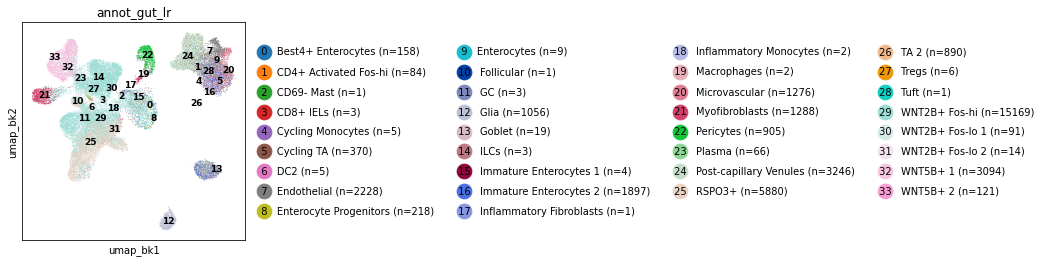

In [86]:
sk.plot_embedding(ad, basis='umap_bk', groupby='annot_gut_lr', size=2, annot='full');

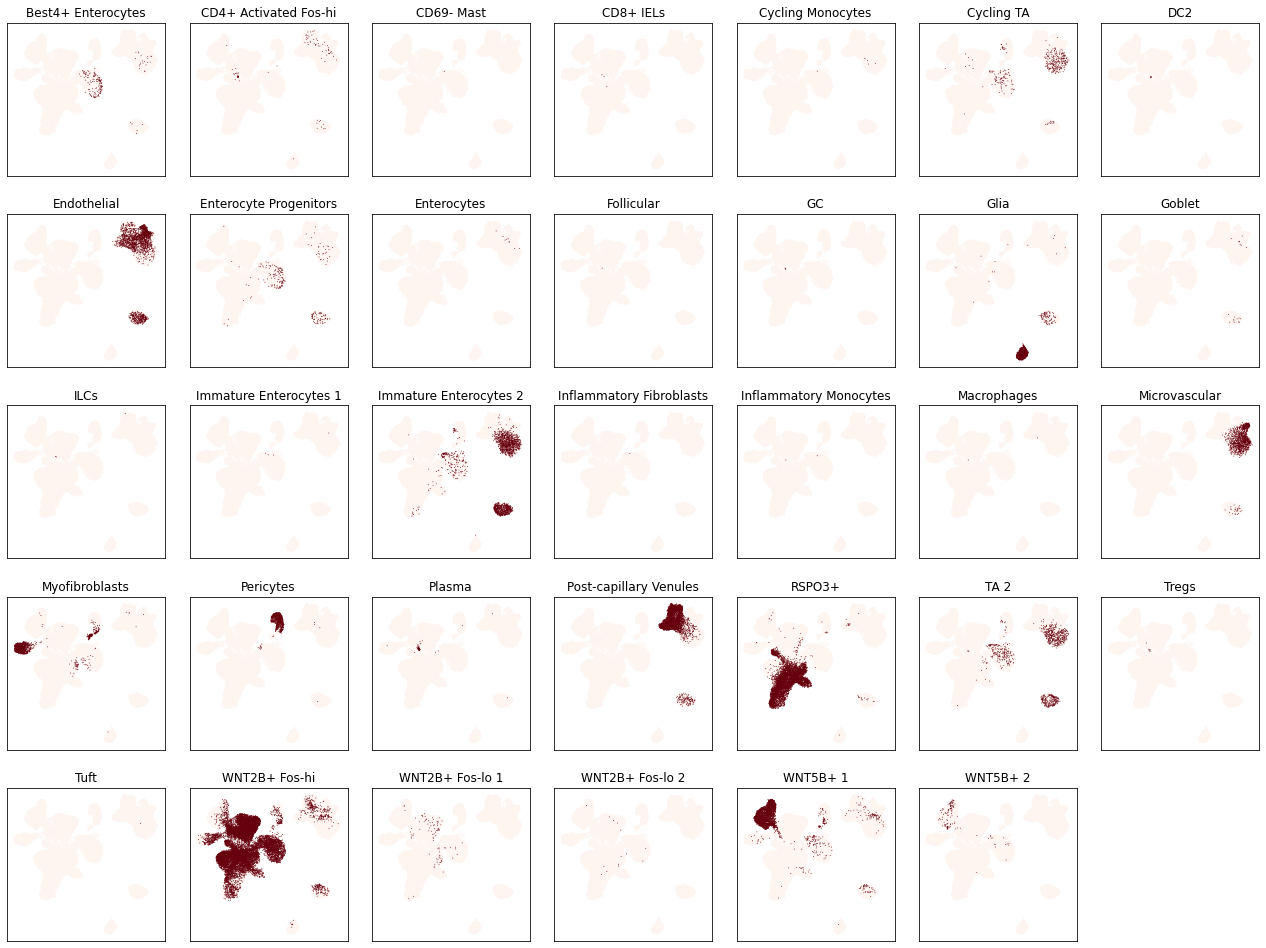

In [85]:
sk.highlight(ad, basis='umap_bk', groupby='annot_gut_lr', figsize=(3,3), wspace=0.05, ncols=7)

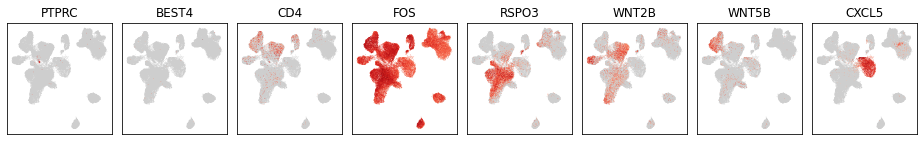

In [10]:
sk.plot_genes(ad, basis='umap_bk', genes=['PTPRC', 'BEST4', 'CD4', 'FOS', 'RSPO3', 'WNT2B', 'WNT5B', 'CXCL5'], size=1)

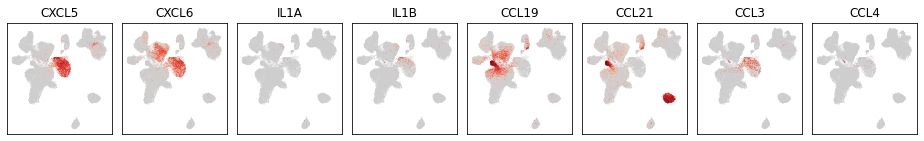

In [17]:
sk.plot_genes(ad, basis='umap_bk', genes=['CXCL5', 'CXCL6', 'IL1A', 'IL1B', 'CCL19', 'CCL21', 'CCL3', 'CCL4'], size=1)

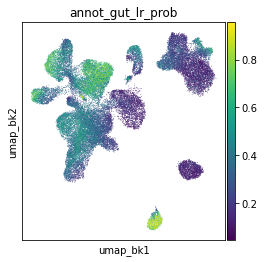

In [228]:
ss.lib.plot_scatter(ad, basis='umap_bk', color='annot_gut_lr_prob', size=2);

### Refine clustering manually

#### Split by step

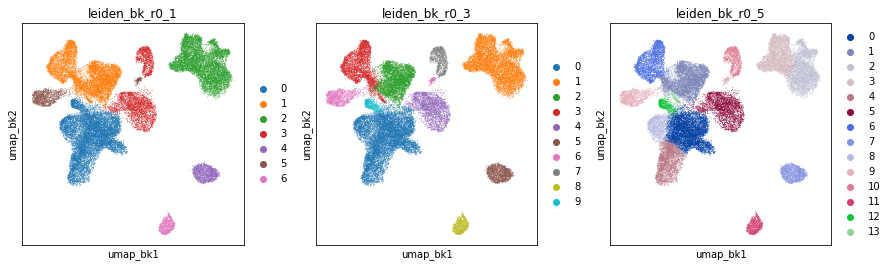

In [114]:
ss.lib.plot_scatter(ad, basis='umap_bk', color=['leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5'], size=2);

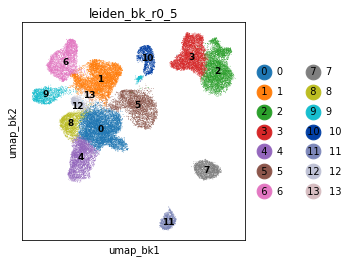

In [134]:
ss.lib.plot_embedding(ad, basis='umap_bk', groupby='leiden_bk_r0_5', size=2);

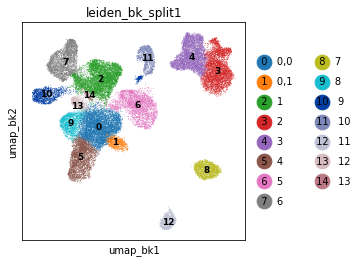

In [142]:
ss.lib.leiden(ad, use_graph='neighbors_bk', restrict_to=('leiden_bk_r0_5', ['0']), resolution=0.17, key_added='bk_split1')
ss.lib.plot_embedding(ad, basis='umap_bk', groupby='leiden_bk_split1', size=2);

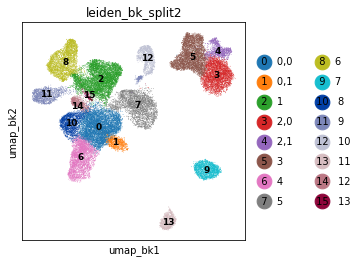

In [144]:
ss.lib.leiden(ad, use_graph='neighbors_bk', restrict_to=('leiden_bk_split1', ['2']), resolution=0.1, key_added='bk_split2')
ss.lib.plot_embedding(ad, basis='umap_bk', groupby='leiden_bk_split2', size=2);

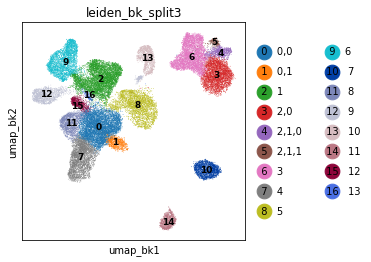

In [147]:
ss.lib.leiden(ad, use_graph='neighbors_bk', restrict_to=('leiden_bk_split2', ['2,1']), resolution=0.2, key_added='bk_split3')
ss.lib.plot_embedding(ad, basis='umap_bk', groupby='leiden_bk_split3', size=2);

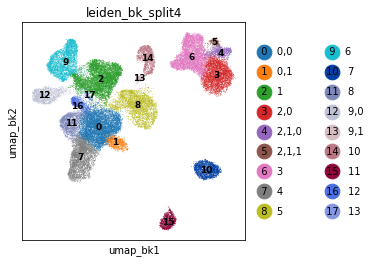

In [162]:
ss.lib.leiden(ad, use_graph='neighbors_bk', restrict_to=('leiden_bk_split3', ['9']), resolution=0.1, key_added='bk_split4')
ss.lib.plot_embedding(ad, basis='umap_bk', groupby='leiden_bk_split4', size=2);

In [178]:
ss.lib.cross_table(ad, 'leiden_bk_split4', 'annot_batch2_lr', normalise='xy', highlight=1)

In [232]:
ad.obs['annot1'] = ss.lib.regroup(ad, 'leiden_bk_split4', regroups=ss.lib.annotate(ad, 'leiden_bk_split4', 'annot_batch2_lr'))

In [37]:
ad.obs.annot1.cat.reorder_categories(sorted(ad.obs.annot1.cat.categories.to_list()), inplace=True)

#### Annotated UMAP

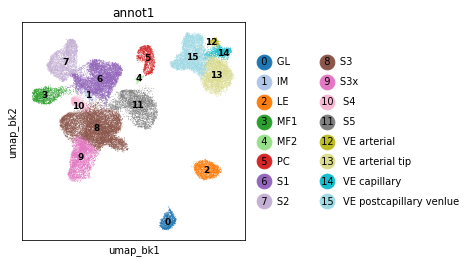

In [38]:
sk.plot_embedding(ad, basis='umap_bk', groupby='annot1', size=2, palette='tab20');

In [48]:
ad.obs.keys()

Index(['doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score',
       'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito',
       'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID',
       'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state',
       'disease', 'site_taken_fine', 'site_taken_broad', 'sorted',
       'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature',
       'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob',
       'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1',
       'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1',
       'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4',
       'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1'],
      dtype='object')

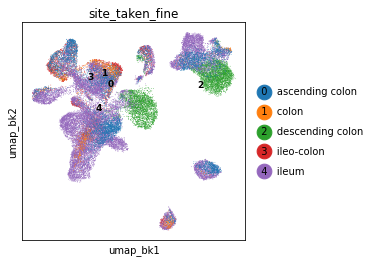

In [51]:
sk.plot_embedding(ad, basis='umap_bk', groupby='site_taken_fine', size=2);

### Markers

In [36]:
mkstR = sk.calc_marker_stats(ad, groupby='annot1')

In [37]:
joblib.dump(mkstR, 'scRNA_batch1_2.annot1_mkst.pkl', compress=True)

['scRNA_batch1_2.annot1_mkst.pkl']

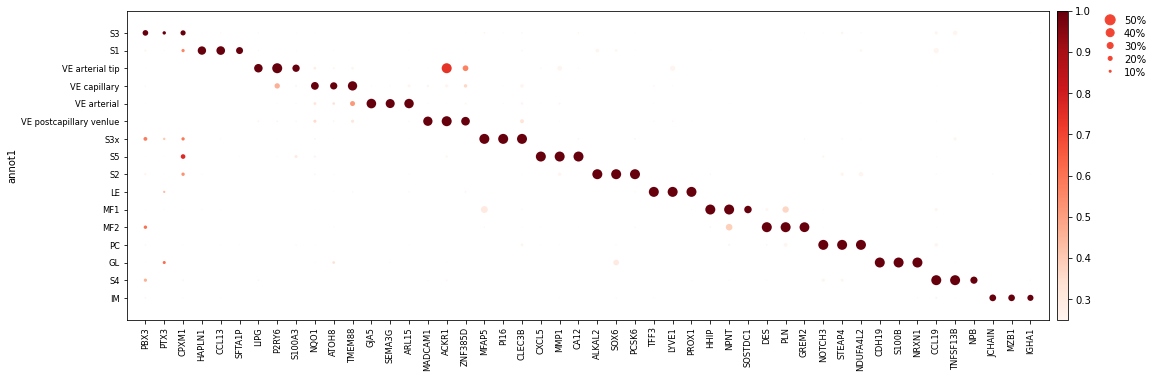

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[16.799999999999997, 0, 0.2, 0.5, 0.25])

In [59]:
mksR = sk.filter_marker_stats(mkstR[2], min_frac_diff=0.05, min_mean_diff=0.05, max_next_frac=0.2, max_next_mean=0.9, single=False, how='and')
sk.plot_markers(ad, groupby='annot1', mks=mksR, standard_scale='var', color_map='Reds', dot_max=0.5, vmin=0.25, n_genes=3)

In [53]:
mks.loc[lambda x: x.top_frac_group.str.startswith('VE')].groupby('top_frac_group').head(5)

top_frac_group  top_frac  frac_diff  max_frac_diff  \
GJA5                  VE arterial  0.480469   0.438413       0.438413   
SEMA3G                VE arterial  0.453125   0.391209       0.391209   
ARL15                 VE arterial  0.472656   0.321955       0.321955   
LTC4S                 VE arterial  0.460938   0.285070       0.285070   
THSD7A                VE arterial  0.398438   0.259419       0.259419   
LIPG              VE arterial tip  0.426041   0.331100       0.331100   
P2RY6             VE arterial tip  0.570230   0.302707       0.302707   
FAM43A            VE arterial tip  0.549099   0.286248       0.286248   
COLGALT1          VE arterial tip  0.528589   0.283987       0.283987   
BACE2             VE arterial tip  0.531386   0.274698       0.274698   
F2RL3                VE capillary  0.567757   0.293052       0.293052   
NQO1                 VE capillary  0.389019   0.235099       0.235099   
ATOH8                VE capillary  0.362150   0.226207       0.226207   
TMEM88               VE capillary  0.466121   0.216121       0.216121   
MCF2L                VE capillary  0.446262   0.213464       0.213464   
MADCAM1   VE postcapillary venlue  0.465356   0.343861       0.343861   
TSPAN7    VE postcapillary venlue  0.483098   0.201848       0.203856   
PLA1A     VE postcapillary venlue  0.200432   0.149030       0.149030   
ZNF385D   VE postcapillary venlue  0.433229   0.147648       0.147648   
HLA-DQA1  VE postcapillary venlue  0.405658   0.146132       0.146132   

                   top_mean_group  top_mean  mean_diff  max_mean_diff  
GJA5                  VE arterial  1.057193   0.986352       0.986352  
SEMA3G                VE arterial  0.933300   0.826668       0.826668  
ARL15                 VE arterial  1.000858   0.743680       0.743680  
LTC4S                 VE arterial  0.992816   0.626506       0.626506  
THSD7A                VE arterial  0.793136   0.534260       0.534260  
LIPG              VE arterial tip  0.805358   0.640741       0.640741  
P2RY6             VE arterial tip  1.132888   0.608256       0.608256  
FAM43A            VE arterial tip  1.121193   0.636679       0.636679  
COLGALT1          VE arterial tip  1.004642   0.631644       0.631644  
BACE2             VE arterial tip  1.016206   0.529454       0.529454  
F2RL3                VE capillary  1.333329   0.809610       0.809610  
NQO1                 VE capillary  0.711664   0.450841       0.450841  
ATOH8                VE capillary  0.687521   0.451591       0.451591  
TMEM88               VE capillary  0.961107   0.464775       0.464775  
MCF2L                VE capillary  0.866107   0.439990       0.439990  
MADCAM1   VE postcapillary venlue  1.235873   0.998860       0.998860  
TSPAN7    VE postcapillary venlue  1.005059   0.454221       0.454221  
PLA1A     VE postcapillary venlue  0.374148   0.289386       0.289386  
ZNF385D   VE postcapillary venlue  0.871299   0.376919       0.376919  
HLA-DQA1  VE postcapillary venlue  0.833187   0.250095       0.264945

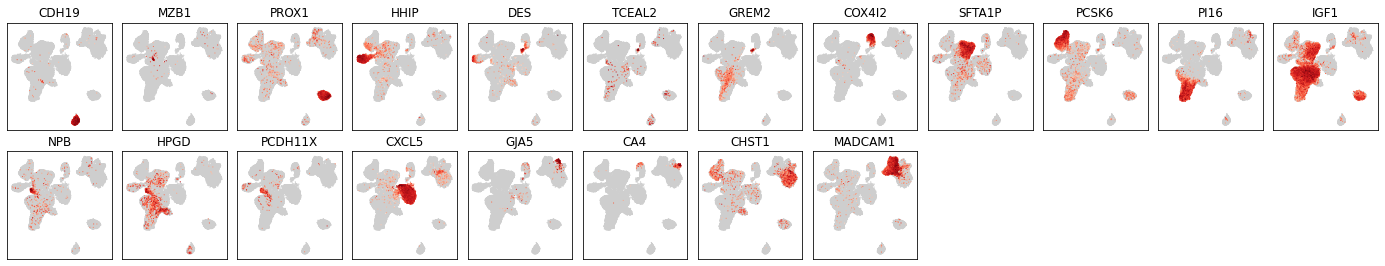

In [93]:
sk.plot_genes(ad, basis='umap_bk', genes=[
    'CDH19', 'MZB1', 'PROX1', 'HHIP', 'DES', 'TCEAL2', 'GREM2', 'COX4I2',
    'SFTA1P', 'PCSK6', 'PI16', 'IGF1', 'NPB', 'HPGD', 'PCDH11X', 'CXCL5',
    'GJA5', 'CA4', 'CHST1', 'MADCAM1'
], size=5)

## Cell type proportions

In [243]:
ad.obs['broad_annot1'] = ss.lib.regroup(ad, 'annot1', regroups={'VE': ['VE arterial tip', 'VE capillary', 'VE arterial', 'VE postcapillary venlue']})

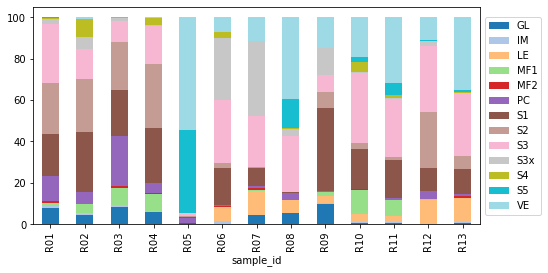

In [244]:
ss.lib.set_figsize((8, 4))
ax = ss.lib.cross_table(ad, 'sample_id', 'broad_annot1', normalise='x').plot.bar(stacked=True, cmap='tab20')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [248]:
ad1 = ad[ad.obs.sample_id!='R05'].copy()

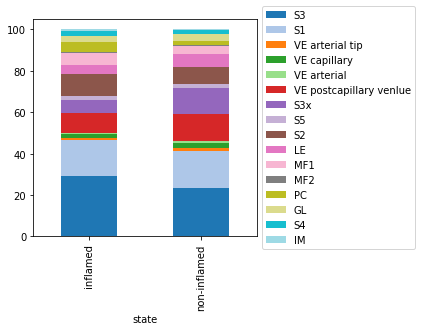

In [250]:
ss.lib.set_figsize((4, 4))
ax = ss.lib.cross_table(ad1, 'state', 'annot1', normalise='x').plot.bar(stacked=True, cmap='tab20')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

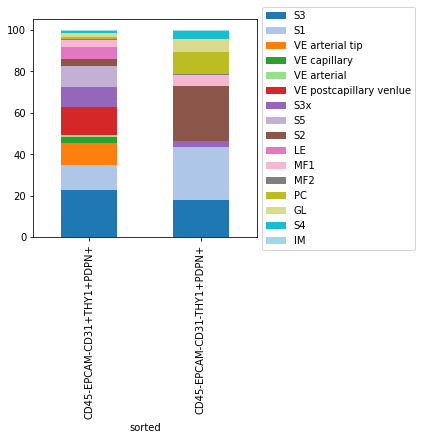

In [254]:
ss.lib.set_figsize((4, 4))
ax = ss.lib.cross_table(ad, 'sorted', 'annot1', normalise='x').plot.bar(stacked=True, cmap='tab20')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

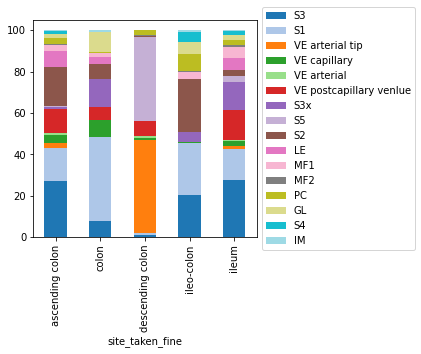

In [253]:
ss.lib.set_figsize((4, 4))
ax = ss.lib.cross_table(ad, 'site_taken_fine', 'annot1', normalise='x').plot.bar(stacked=True, cmap='tab20')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

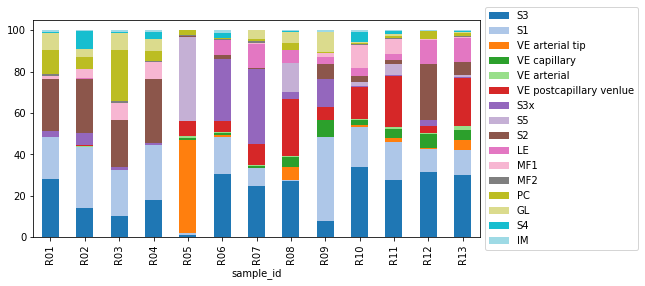

In [245]:
ss.lib.set_figsize((8, 4))
ax = ss.lib.cross_table(ad, 'sample_id', 'annot1', normalise='x').plot.bar(stacked=True, cmap='tab20')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Save objects

In [256]:
sk.clear_colors(ad)
ad.write('scRNA_batch1_2.processed.h5ad', compression='lzf')

In [35]:
ad = sc.read('scRNA_batch1_2.processed.h5ad')

In [184]:
adS = ss.lib.subsample(ad, 0.1, groupby='leiden_bk_split4', min_n=200, max_n=500)

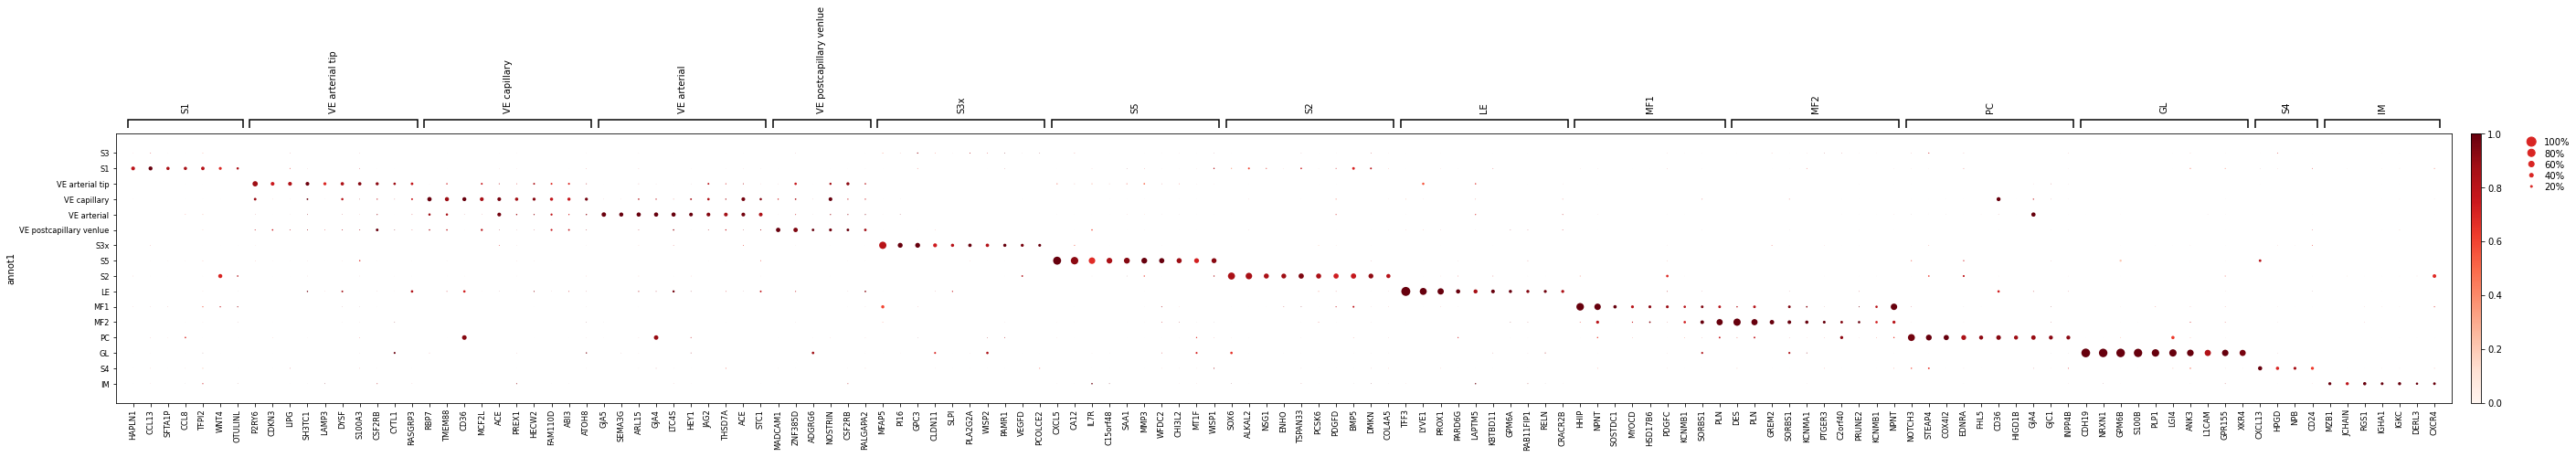

In [199]:
sc.pl.rank_genes_groups_dotplot(adS, key='rank_genes_groups_annot1_filtered', groupby='annot1', mean_only_expressed=True, standard_scale='var', dendrogram=False)

In [257]:
ss.lib.clear_colors(adS)
adS.write('scRNA_batch1_2.processed.downsampled.h5ad', compression='lzf')

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/anndata/readwrite/write.py:308: UserWarning: Could not save field with key = 'uns/rank_genes_groups_bk_split4_filtered/names' to hdf5 file: invalid literal for int() with base 10: ''
  .format(key, e)
/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/anndata/readwrite/write.py:308: UserWarning: Could not save field with key = 'uns/rank_genes_groups_annot1_filtered/names' to hdf5 file: invalid literal for int() with base 10: ''
  .format(key, e)


In [42]:
adS = sc.read('scRNA_batch1_2.processed.downsampled.h5ad')

Only considering the two last: ['.downsampled', '.h5ad'].
Only considering the two last: ['.downsampled', '.h5ad'].


# Process scATAC

## Gene matrix

In [91]:
genes = pd.read_csv('../20201116_scATAC_batch1_2/scATAC_GeneSet.tsv', sep='\t')

In [92]:
genes.head()

seqnames   start     end  width strand    gene_id        symbol
0     chr1   69091   70008    918      +      79501         OR4F5
1     chr1  139790  140339    550      -     729737     LOC729737
2     chr1  585990  629010  43021      -  101928626  LOC101928626
3     chr1  632325  632413     89      -  102465432           NaN
4     chr1  817371  819837   2467      +     400728        FAM87B

In [6]:
norm_ad = sc.read('../20201116_scATAC_batch1_2/scATAC_GeneScoreMatrix.norm.h5ad')

In [7]:
norm_ad

AnnData object with n_obs × n_vars = 86161 × 24919 
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot'
    var: 'seqnames', 'start', 'end', 'strand', 'name', 'idx'

In [8]:
norm_ad.obs.Sample.cat.rename_categories({'NX02': 'A01', 'NX10': 'A02', 'NX18': 'A03', 'NX26': 'A04'}, inplace=True)
norm_ad.obs.Sample.cat.reorder_categories([f'A{i+1:02d}' for i in range(13)], inplace=True)

In [9]:
obs_df = norm_ad.obs.reset_index().merge(meta_df, how='left', left_on='Sample', right_on='ATAC_SID').set_index('index')

In [10]:
np.all(norm_ad.obs_names == obs_df.index)

True

In [11]:
norm_ad.obs = obs_df.copy()

In [12]:
norm_ad.var['cc'] = norm_ad.var_names.isin(cc_genes)

### QC

In [18]:
X = norm_ad.X.tocsr()

In [19]:
norm_ad.X = X

In [20]:
sk.calculate_qc(norm_ad)

In [22]:
norm_ad.obs['n_counts'] = norm_ad.obs['nFrags']
norm_ad.obs['log1p_n_counts'] = np.log1p(norm_ad.obs['nFrags'])
norm_ad.obs['scrublet_score_z'] = norm_ad.obs['DoubletScore'].copy()

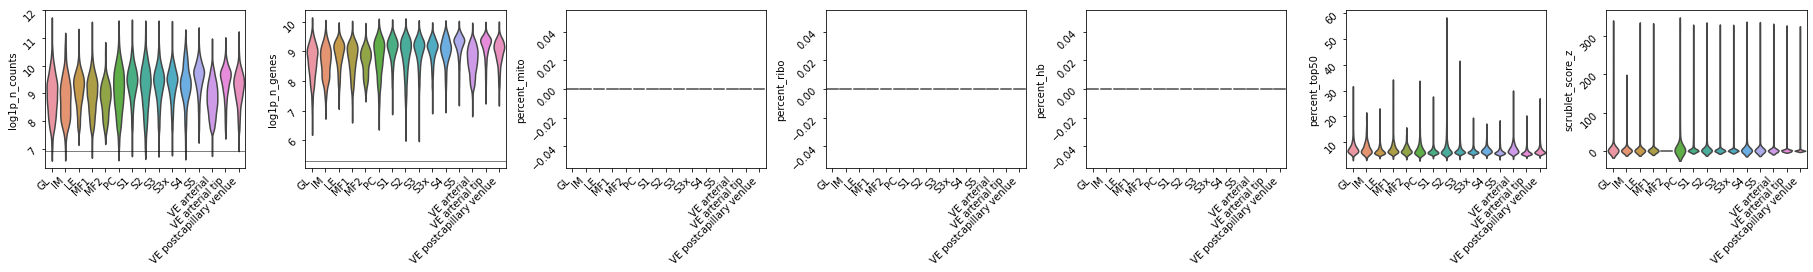

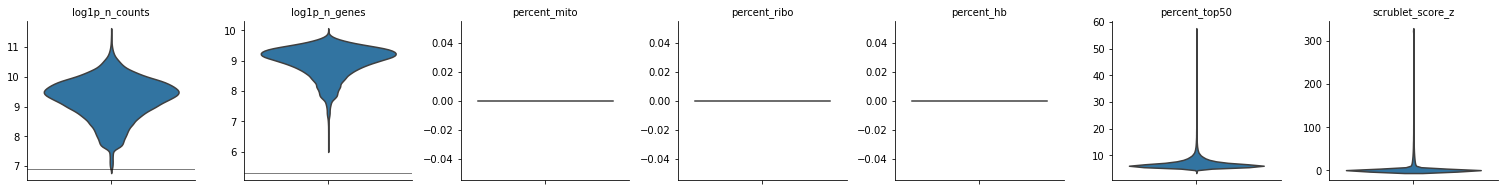

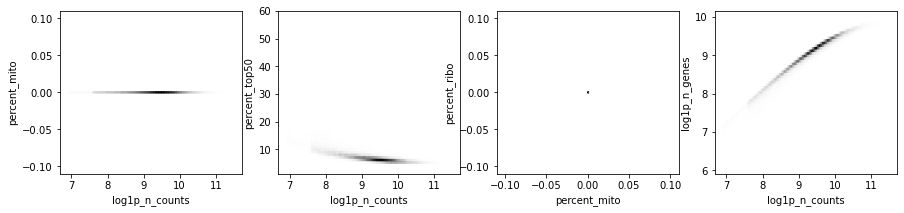

In [23]:
sk.set_figsize((4, 3))
sk.plot_qc(norm_ad, groupby='Annot')

In [25]:
norm_ad.obs.columns

Index(['BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags',
       'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio',
       'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS',
       'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un',
       'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co',
       'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm',
       'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm',
       'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm',
       'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'GEX_SID',
       'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date',
       'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad',
       'sorted', 'Nancy_histologic_score', 'slide_look_other',
       'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts',
       'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito',


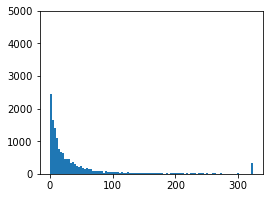

In [124]:
plt.hist(norm_ad.obs.DoubletScore[norm_ad.obs.DoubletScore>0], 100);
plt.ylim(0, 5000);

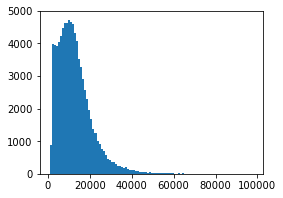

In [26]:
plt.hist(norm_ad.obs.nFrags, 100);
plt.ylim(0, 5000);

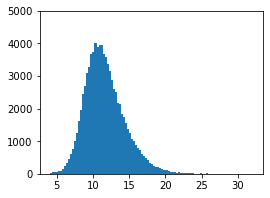

In [27]:
plt.hist(norm_ad.obs.TSSEnrichment, 100);
plt.ylim(0, 5000);

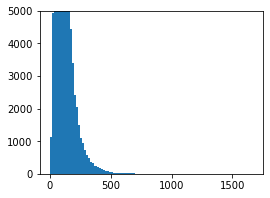

In [28]:
plt.hist(norm_ad.obs.ReadsInBlacklist, 100);
plt.ylim(0, 5000);

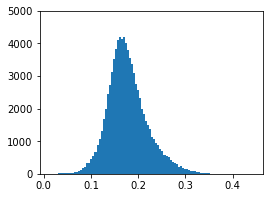

In [29]:
plt.hist(norm_ad.obs.PromoterRatio, 100);
plt.ylim(0, 5000);

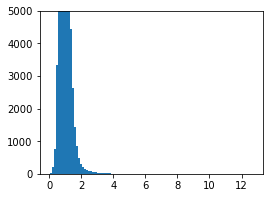

In [30]:
plt.hist(norm_ad.obs.NucleosomeRatio, 100);
plt.ylim(0, 5000);

In [31]:
k_passqc = (
    (norm_ad.obs.percent_top50<=20) & (norm_ad.obs.DoubletScore<=30) & (norm_ad.obs.TSSEnrichment>=5) & (norm_ad.obs.TSSEnrichment<=23) &
    (norm_ad.obs.ReadsInBlacklist<=500) & (norm_ad.obs.PromoterRatio>=0.1) & (norm_ad.obs.PromoterRatio<=0.3) & (norm_ad.obs.NucleosomeRatio<=3)
)

In [32]:
norm_ad1 = norm_ad[k_passqc].copy()

In [33]:
sc.pp.log1p(norm_ad1)

In [34]:
norm_ad1

AnnData object with n_obs × n_vars = 78474 × 24919 
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percen

### Run pipeline

In [35]:
atac_ad = sk.simple_default_pipeline(
    norm_ad1.copy(), post_norm_only=True, batch='ATAC_SID', batch_method='bbknn', do_clustering=False,
    hvg_kw={'by_batch': ('ATAC_SID', 3), 'n_hvg': 3000, 'mean_limits': [0.1, 2]},
    pca_kw={'remove_genes': ['cc']},
    bk_kw={'trim': 50}
)

In [36]:
gc.collect()

46978

In [175]:
sk.simple_default_pipeline(atac_ad, post_pca_only=True, do_clustering=False);

In [167]:
atac_ad

AnnData object with n_obs × n_vars = 81013 × 24766 
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'scrublet_score_z', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_si

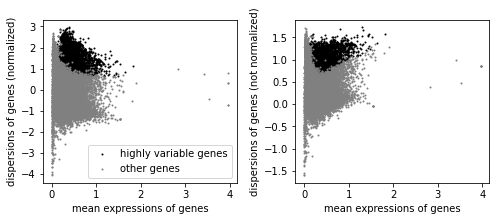

In [37]:
sc.pl.highly_variable_genes(atac_ad)

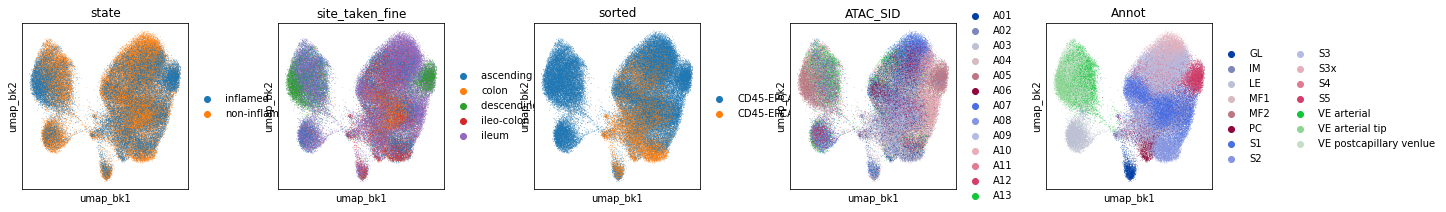

In [38]:
sk.set_figsize((3,3))
sk.plot_scatter(atac_ad, basis='umap_bk', color=['state', 'site_taken_fine', 'sorted', 'ATAC_SID', 'Annot'], ncols=6, wspace=0.4)

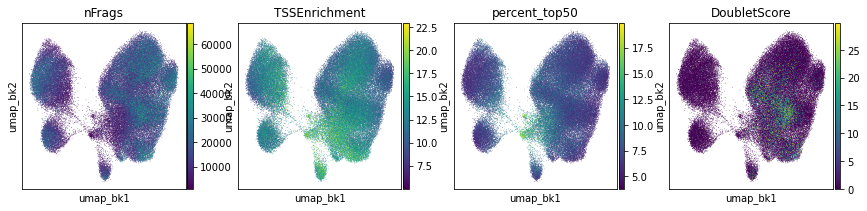

In [39]:
sk.set_figsize((3,3))
sk.plot_scatter(atac_ad, basis='umap_bk', color=['nFrags', 'TSSEnrichment', 'percent_top50', 'DoubletScore'], ncols=6, wspace=0.2)

### Save object

In [40]:
atac_ad.write('../20201116_scATAC_batch1_2/scATAC_GeneScoreMatrix.processed.h5ad', compression='lzf')

In [3]:
atacG_ad = sc.read('../20201116_scATAC_batch1_2/scATAC_GeneScoreMatrix.processed.h5ad')

In [94]:
atacG_ad

AnnData object with n_obs × n_vars = 78474 × 24766 
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percen

In [25]:
atacG_ad.var_names = atacG_ad.var.name.values
tmp_raw = anndata.AnnData(X=atacG_ad.raw.X, obs=atacG_ad.obs.copy(), var=atacG_ad.raw.var.copy())
tmp_raw.var_names = tmp_raw.var.name.values
atacG_ad.raw = tmp_raw

In [8]:
atacG_ad = atacG_ad[atacG_ad.obs_names.isin(atacP_ad.obs_names)].copy()

In [11]:
atacG_ad.obsm['X_umap_bk2'] = atacP_ad.obsm['X_umap_bk'][atacP_ad.obs_names.isin(atacG_ad.obs_names), :]

In [31]:
atacG_adS = sk.subsample(atacG_ad, 1, groupby='Annot', min_n=500, max_n=500)

In [32]:
atacG_adS.write('../20201116_scATAC_batch1_2/scATAC_GeneScoreMatrix.processed.downsampled.h5ad', compression='lzf')

## Peak matrix

In [2]:
peaks = pd.read_csv('../20201116_scATAC_batch1_2/scATAC_PeakSet.tsv.gz', sep='\t', index_col=17)

In [3]:
norm_ad = sc.read('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.norm.h5ad')

In [4]:
norm_ad.var_names = peaks.index.values

In [13]:
norm_ad

AnnData object with n_obs × n_vars = 86161 × 407383 
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'Clusters1', 'ReadsInPeaks', 'FRIP', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq'
    var: 'idx', 'cc'

In [14]:
norm_ad.X

<86161x407383 sparse matrix of type '<class 'numpy.float32'>'
	with 631911581 stored elements in Compressed Sparse Column format>

In [6]:
norm_ad.obs.Sample.cat.categories

Index(['A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'NX02',
       'NX10', 'NX18', 'NX26'],
      dtype='object')

In [5]:
norm_ad.obs.Sample.cat.rename_categories({'NX02': 'A01', 'NX10': 'A02', 'NX18': 'A03', 'NX26': 'A04'}, inplace=True)
norm_ad.obs.Sample.cat.reorder_categories([f'A{i+1:02d}' for i in range(13)], inplace=True)

In [8]:
obs_df = norm_ad.obs.reset_index().merge(meta_df, how='left', left_on='Sample', right_on='ATAC_SID').set_index('index')

In [10]:
np.all(norm_ad.obs_names == obs_df.index)

True

In [9]:
norm_ad.obs = obs_df.copy()

### QC

In [10]:
X = norm_ad.X.tocsr()

In [11]:
norm_ad.X = X

In [12]:
sk.calculate_qc(norm_ad)

In [13]:
norm_ad.obs['n_counts'] = norm_ad.obs['nFrags']
norm_ad.obs['log1p_n_counts'] = np.log1p(norm_ad.obs['nFrags'])
norm_ad.obs['scrublet_score_z'] = norm_ad.obs['DoubletScore'].copy()

... storing 'Sample_x' as categorical
... storing 'GEX_SID' as categorical
... storing 'ATAC_SID' as categorical
... storing 'GEX' as categorical
... storing 'ATAC' as categorical
... storing 'Sample_y' as categorical
... storing 'DOB' as categorical
... storing 'Gender' as categorical
... storing 'date' as categorical
... storing 'state' as categorical
... storing 'disease' as categorical
... storing 'site_taken_fine' as categorical
... storing 'site_taken_broad' as categorical
... storing 'sorted' as categorical
... storing 'slide_look_other' as categorical
... storing 'whole_tissue_signature' as categorical
... storing 'scSeq' as categorical
... storing 'bulkSeq' as categorical


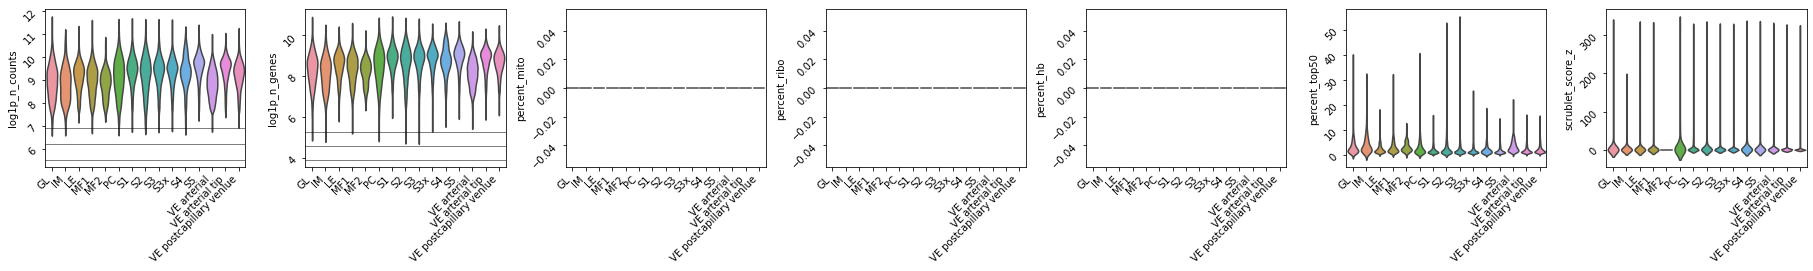

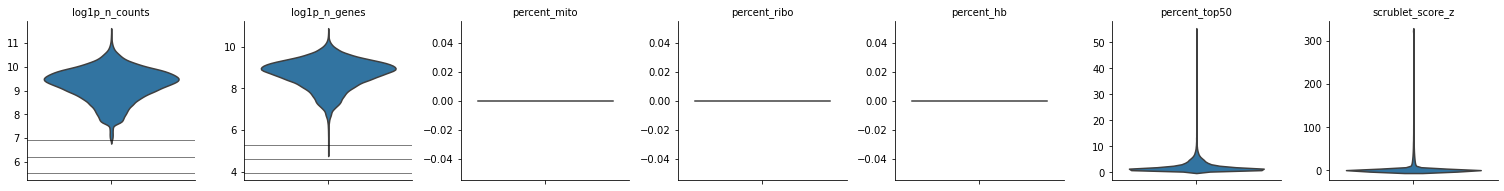

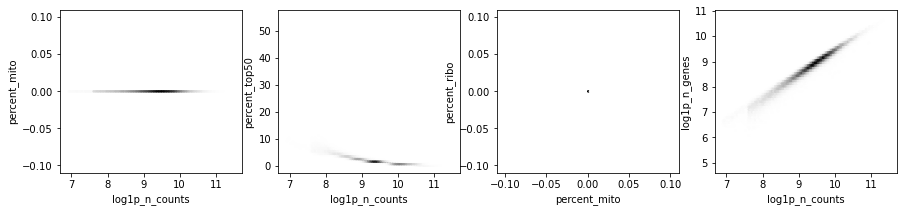

In [14]:
sk.set_figsize((4, 3))
sk.plot_qc(norm_ad, groupby='Annot')

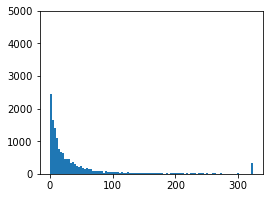

In [20]:
plt.hist(norm_ad.obs.DoubletScore[norm_ad.obs.DoubletScore>0], 100);
plt.ylim(0, 5000);

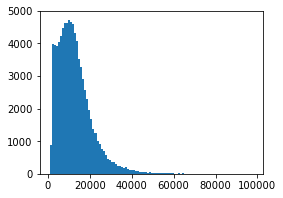

In [21]:
plt.hist(norm_ad.obs.nFrags, 100);
plt.ylim(0, 5000);

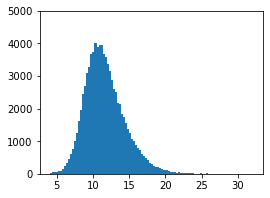

In [22]:
plt.hist(norm_ad.obs.TSSEnrichment, 100);
plt.ylim(0, 5000);

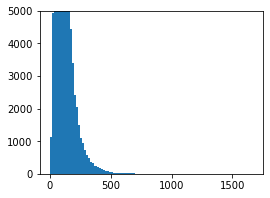

In [23]:
plt.hist(norm_ad.obs.ReadsInBlacklist, 100);
plt.ylim(0, 5000);

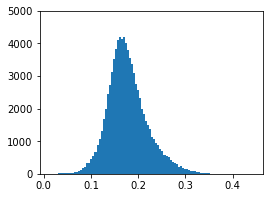

In [24]:
plt.hist(norm_ad.obs.PromoterRatio, 100);
plt.ylim(0, 5000);

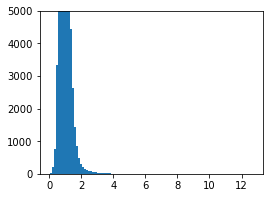

In [25]:
plt.hist(norm_ad.obs.NucleosomeRatio, 100);
plt.ylim(0, 5000);

In [ ]:
k_passqc = (
    (norm_ad.obs.percent_top50<10) & (norm_ad.obs.DoubletScore<=30) & (norm_ad.obs.TSSEnrichment>=5.5) & (norm_ad.obs.TSSEnrichment<=20) &
    (norm_ad.obs.ReadsInBlacklist<=500) & (norm_ad.obs.PromoterRatio>=0.1) & (norm_ad.obs.PromoterRatio<=0.3) & (norm_ad.obs.NucleosomeRatio<=3)
)

In [20]:
norm_ad1 = norm_ad[k_passqc].copy()

In [21]:
sc.pp.log1p(norm_ad1)

In [34]:
norm_ad1

AnnData object with n_obs × n_vars = 78474 × 24919 
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percen

### Run pipeline

In [22]:
atac_ad = sk.simple_default_pipeline(
    norm_ad1.copy(), post_norm_only=True, batch='ATAC_SID', batch_method='bbknn', do_clustering=False,
    hvg_kw={'by_batch': ('ATAC_SID', 3), 'n_hvg': 5000, 'mean_limits': [0.05, 2]},
    pca_kw={'remove_genes': ['cc']},
    bk_kw={'trim': 50}
)

In [23]:
gc.collect()

53973

In [5]:
atac_ad

AnnData object with n_obs × n_vars = 77712 × 407383 
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'Clusters1', 'ReadsInPeaks', 'FRIP', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito',

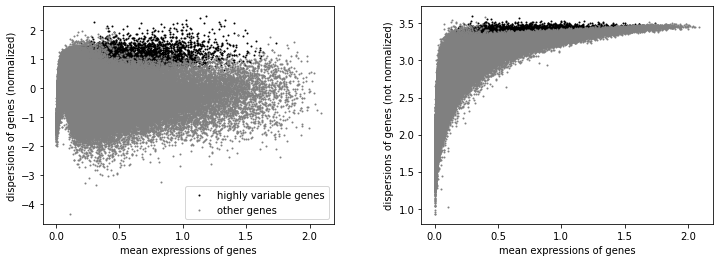

In [6]:
sc.pl.highly_variable_genes(atac_ad)

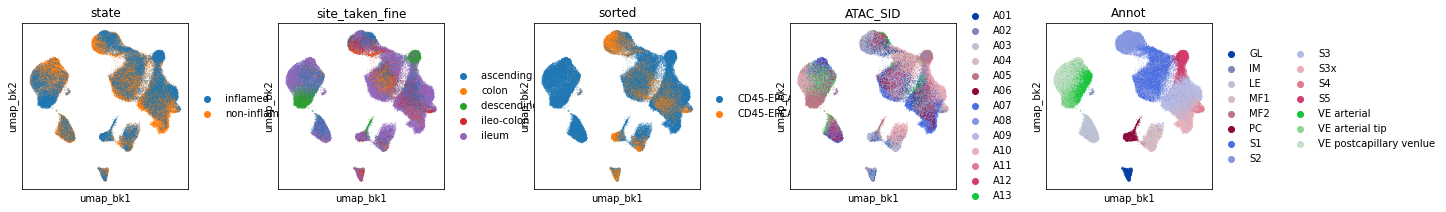

In [7]:
sk.set_figsize((3,3))
sk.plot_scatter(atac_ad, basis='umap_bk', color=['state', 'site_taken_fine', 'sorted', 'ATAC_SID', 'Annot'], ncols=6, wspace=0.4)

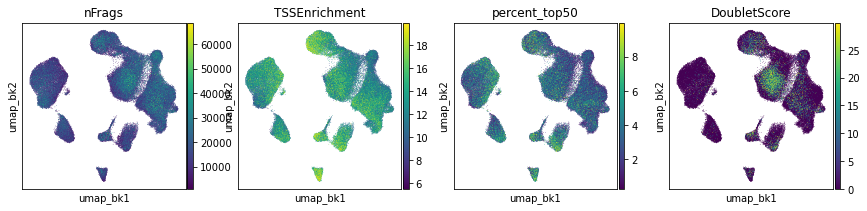

In [8]:
sk.set_figsize((3,3))
sk.plot_scatter(atac_ad, basis='umap_bk', color=['nFrags', 'TSSEnrichment', 'percent_top50', 'DoubletScore'], ncols=6, wspace=0.2)

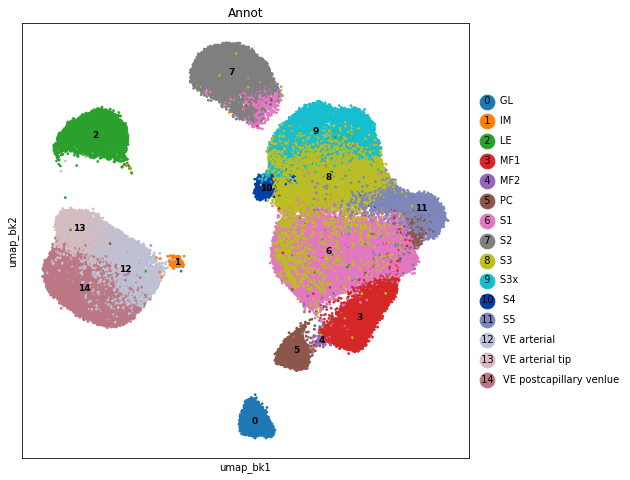

In [27]:
sk.plot_embedding(atac_ad, basis='umap_bk', groupby='Annot', figsize=(8,8), size=30);

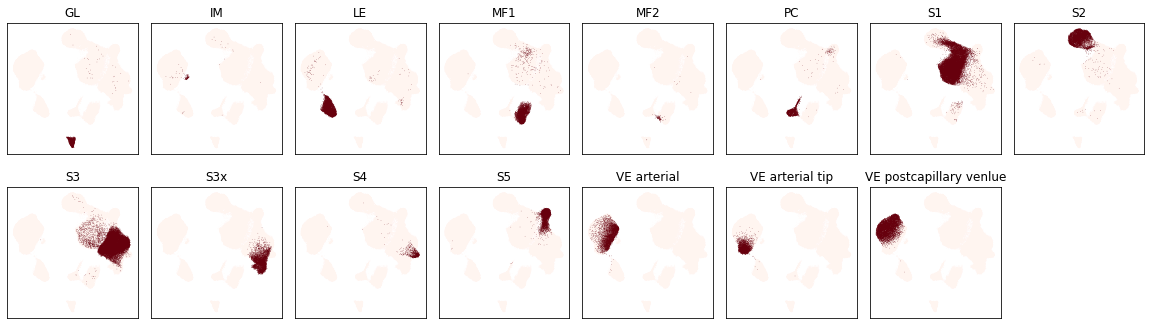

In [51]:
sk.highlight(atac_ad, basis='umap_bk', groupby='Annot', figsize=(2.5, 2.5), size=1, wspace=0, ncols=8);

In [ ]:
sk.leiden(atac_ad, use_graph='neighbors_bk', resolution=[0.3, 0.5, 0.7], key_added='bk')

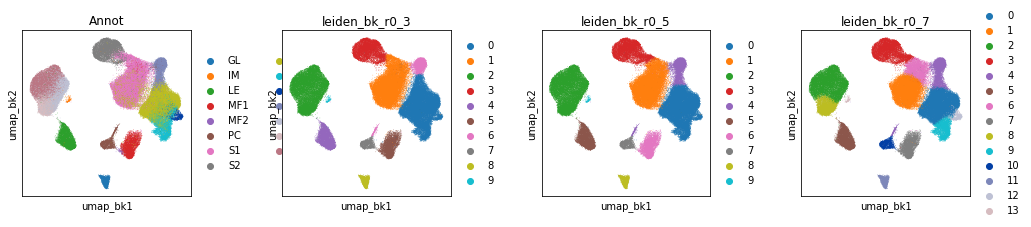

In [41]:
sk.set_figsize((3,3))
sk.plot_scatter(atac_ad, basis='umap_bk', color=['Annot', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'leiden_bk_r0_7'], ncols=6, wspace=0.4)

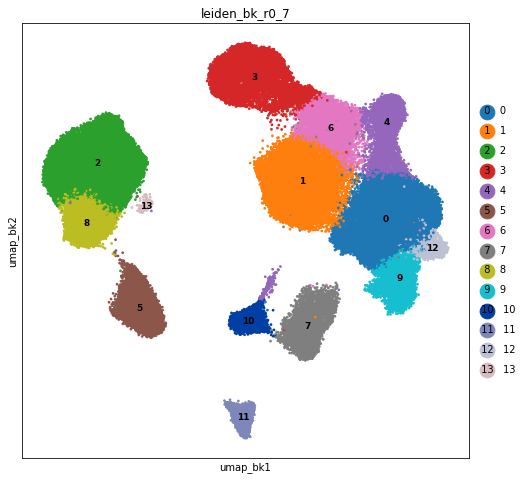

In [46]:
sk.plot_embedding(atac_ad, basis='umap_bk', groupby='leiden_bk_r0_7', figsize=(8,8), size=30);

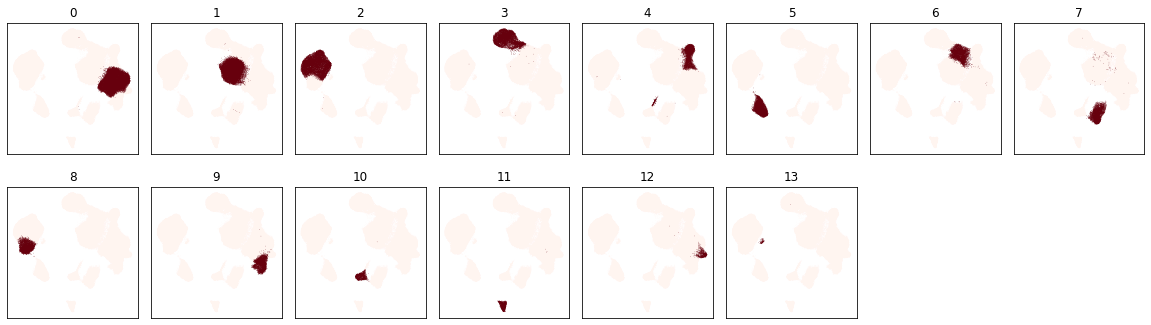

In [52]:
sk.highlight(atac_ad, basis='umap_bk', groupby='leiden_bk_r0_7', figsize=(2.5, 2.5), size=1, wspace=0, ncols=8);

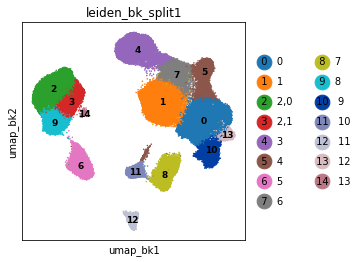

In [63]:
sk.leiden(atac_ad, use_graph='neighbors_bk', restrict_to=('leiden_bk_r0_7', ['2']), resolution=0.17, key_added='bk_split1')
sk.plot_embedding(atac_ad, basis='umap_bk', groupby='leiden_bk_split1', size=10);

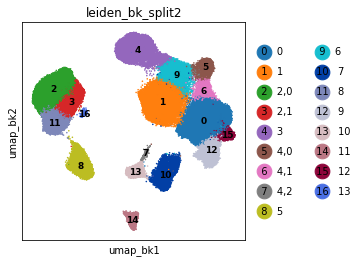

In [64]:
sk.leiden(atac_ad, use_graph='neighbors_bk', restrict_to=('leiden_bk_split1', ['4']), resolution=0.2, key_added='bk_split2')
sk.plot_embedding(atac_ad, basis='umap_bk', groupby='leiden_bk_split2', size=10);

In [69]:
del atac_ad.obs['leiden_bk_split3']

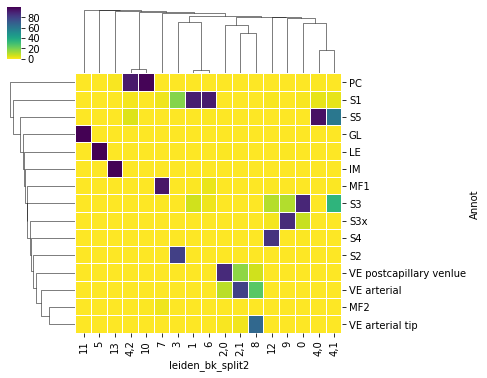

In [62]:
sk.cross_table(atac_ad, 'Annot', 'leiden_bk_split2', normalise='y', plot=True, cluster=True, figsize=(6, 6));

In [72]:
atac_ad.obs['annot1'] = sk.regroup(atac_ad, groupby='leiden_bk_split2', regroups=sk.annotate(atac_ad, groupby='leiden_bk_split2', label='Annot'))

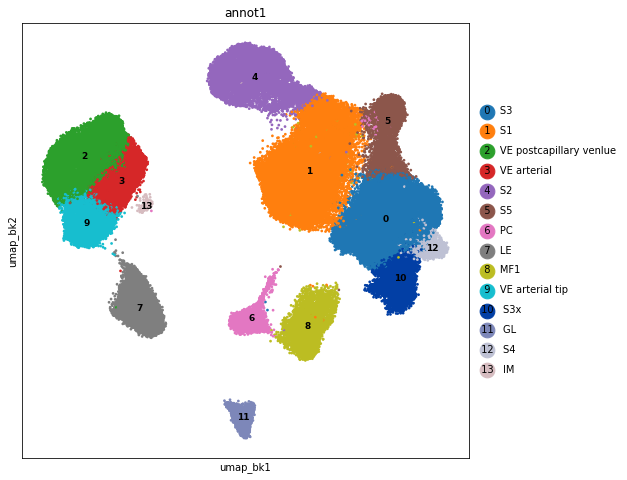

In [73]:
sk.plot_embedding(atac_ad, basis='umap_bk', groupby='annot1', figsize=(8,8), size=30);

### Save project

In [11]:
sk.clear_colors(atac_ad)
atac_ad.write('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.processed.h5ad', compression='lzf')

In [60]:
atac_adS = sk.subsample(atac_ad, 1, groupby='annot1', min_n=500, max_n=500)

In [61]:
sk.clear_colors(atac_adS)
atac_adS.write('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.processed.downsampled.h5ad', compression='lzf')

In [4]:
atacP_ad = sc.read('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.processed.h5ad')

In [5]:
atacP_ad.obs.annot1.cat.reorder_categories(atacP_ad.obs.annot1.cat.categories.sort_values(), inplace=True)

In [56]:
atacP_ad.obs.to_csv('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.filtered_obs.csv.gz')

In [57]:
pd.DataFrame(atacP_ad.obsm['X_umap_bk']).to_csv('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.filtered_umap_bk.csv.gz', index=False, header=False)

### Find marker peaks

In [6]:
mkst = sk.calc_marker_stats(atacP_ad, groupby='annot1')

In [7]:
joblib.dump(mkst, '../20201116_scATAC_batch1_2/scATAC_PeakMatrix.annot1_mkst.pkl', compress=True)

['../20201116_scATAC_batch1_2/scATAC_PeakMatrix.annot1_mkst.pkl']

In [14]:
mks = sk.filter_marker_stats(mkst[2], min_frac_diff=0.1, max_next_frac=0.5, min_mean_diff=0.1, max_next_mean=0.9, how='or', single=False)

In [15]:
mks1 = mks[mks.index.str.endswith('Promoter')]

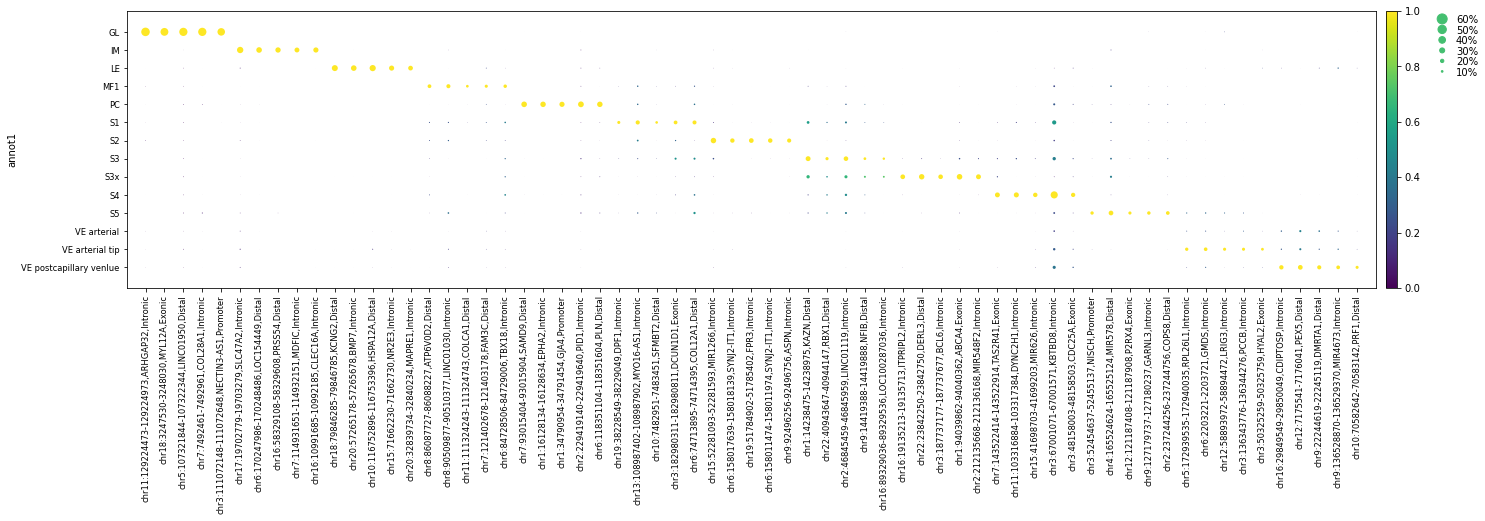

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[22.75, 0, 0.2, 0.5, 0.25])

In [78]:
sk.plot_markers(atac_ad, groupby='annot1', mks=mks, color_map='viridis', standard_scale='var', n_genes=5)

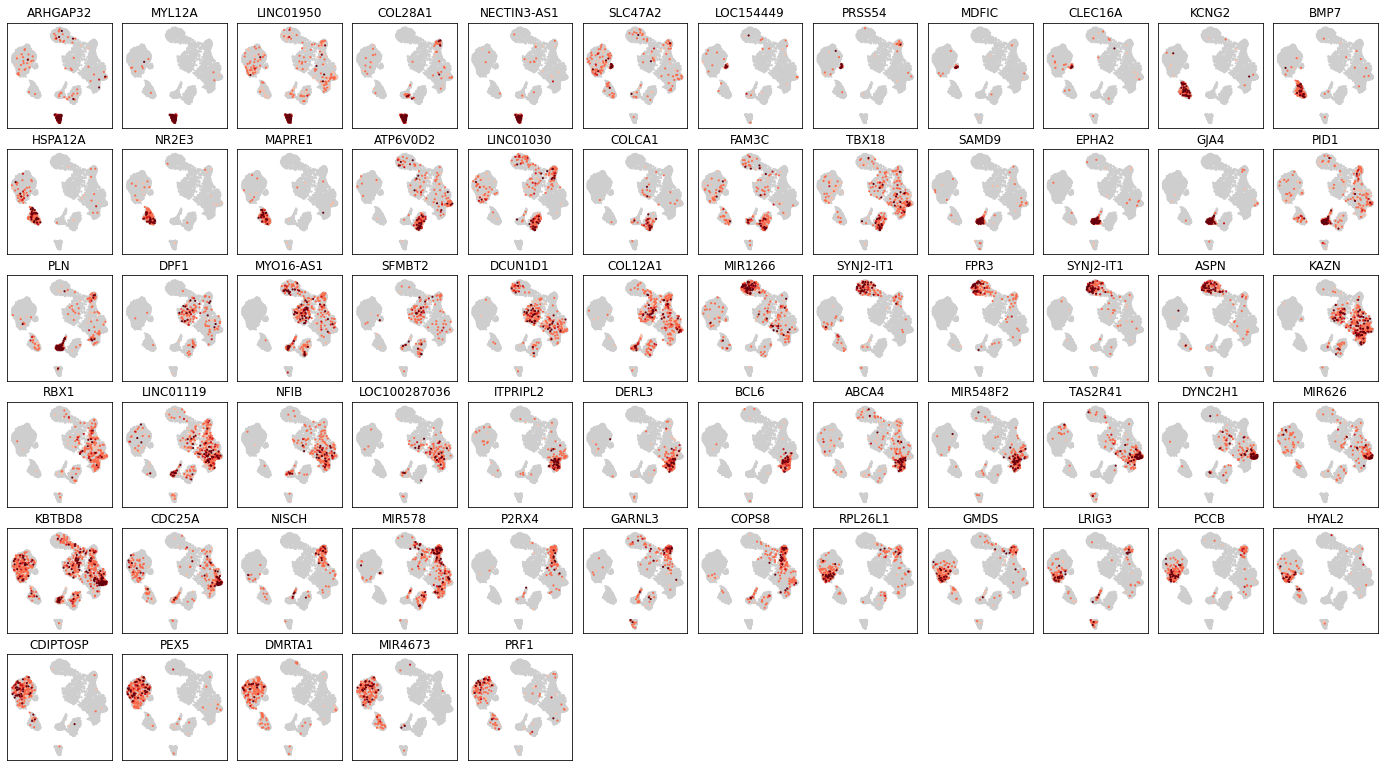

In [81]:
sk.plot_genes(
    atac_adS, basis='umap_bk', genes=mks.groupby('top_frac_group').head(5).index.to_list(), title_func=lambda x: x.split(',')[1]
)

In [101]:
atacG_ad

AnnData object with n_obs × n_vars = 78474 × 24766 
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percen

In [20]:
'name' in atacG_adS.raw.var.columns

True

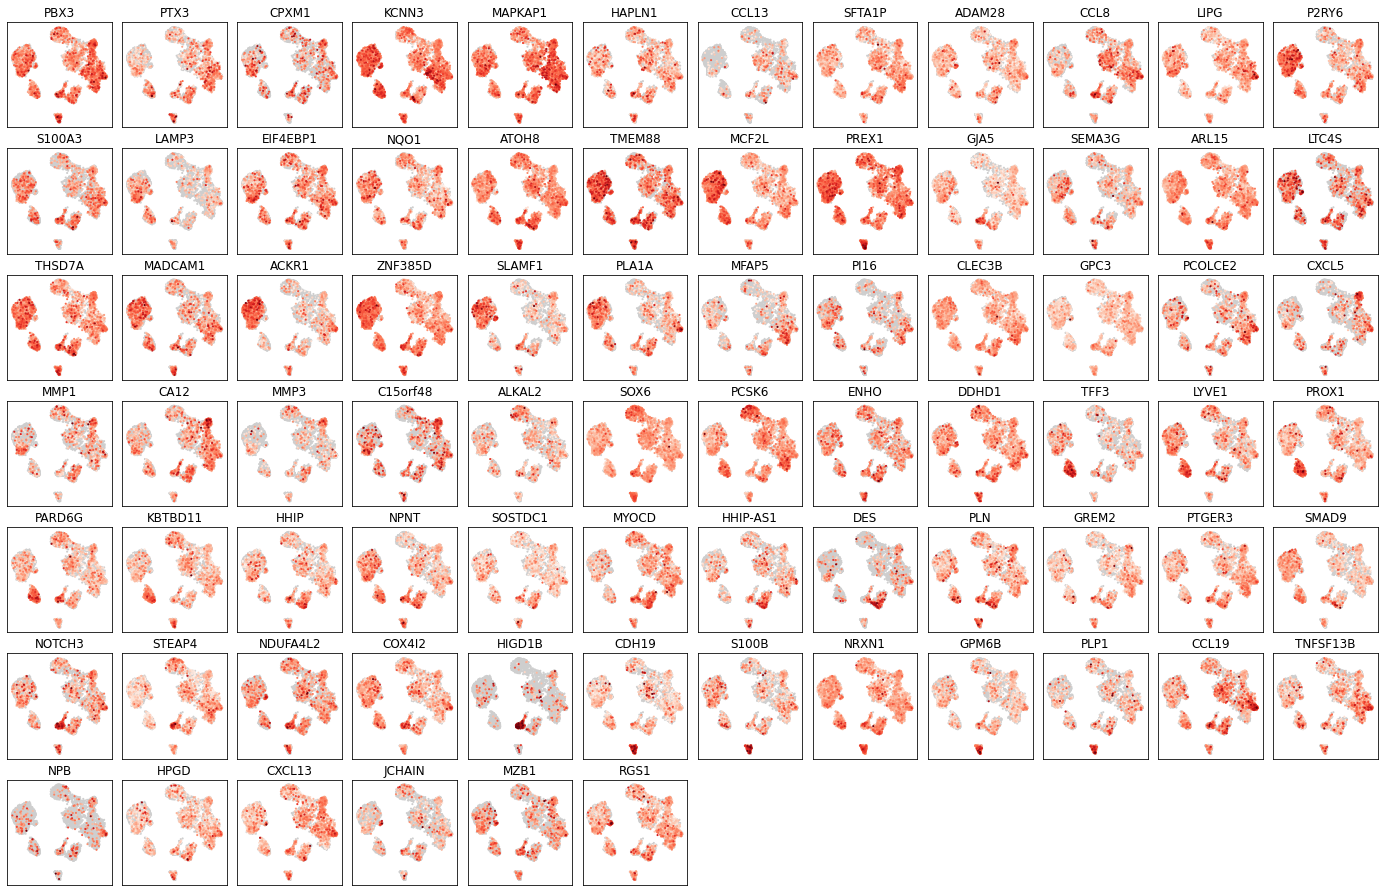

In [51]:
sk.plot_genes(
    atacG_adS, basis='umap_bk2', use_raw=False,
    genes=mksR.groupby('top_frac_group').head(5).index.to_list(),
#     genes=pd.Series(mks1.groupby('top_frac_group').head(5).index).str.partition(',')[2].str.partition(',')[0].to_list(),
)

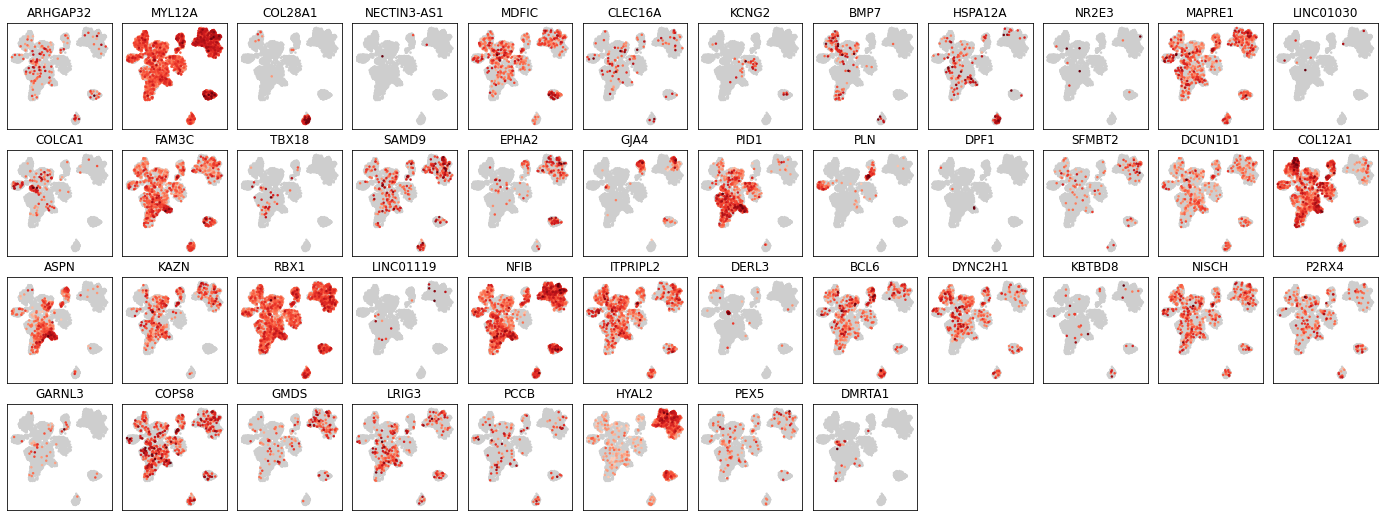

In [83]:
sk.plot_genes(
    adS, basis='umap_bk', genes=pd.Series(mks.groupby('top_frac_group').head(5).index).str.partition(',')[2].str.partition(',')[0].to_list(),
)